In [1]:
from src.visualise import settings
from src.data.paths import project_dir

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from lmfit.models import StepModel, LinearModel

from pathlib import Path

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# Efficiency data

In [2]:
df = pd.read_hdf(project_dir / 'data' / 'interim' / 'data.h5', key='df')
df

,det_no,mean_signal,std_signal,radiation,circle_no
14000,2,302.980892,43.017841,Co60,0
14001,2,285.377778,41.374252,Co60,1
14002,2,304.148734,45.636775,Co60,2
14003,2,297.772871,46.431648,Co60,3
14004,2,289.338658,45.850783,Co60,4
...,...,...,...,...,...
13995,15,7.386076,10.094631,proton,995
13996,15,6.056962,8.936657,proton,996
13997,15,7.289308,10.013416,proton,997
13998,15,7.895238,9.934634,proton,998


In [3]:
df2 = pd.DataFrame()
df2["mean"] = df.groupby(["radiation", "det_no"])["mean_signal"].mean()
df2["std"] = df.groupby(["radiation", "det_no"])["mean_signal"].std()
df2

mean        std
radiation det_no                        
Co60      2        293.958297   5.283159
          3        259.751904   5.445506
          4        306.881430   8.497562
          5        298.239225   4.873268
          6        262.931823   4.922753
          7        306.109932  12.726056
          8        269.006936   4.157138
          9        286.741279   5.084650
          10       289.412934   5.527264
          11       291.488228   6.337839
          12       334.309117   4.530066
          13       304.342306   5.519089
          14       317.524954   5.886024
          15       285.868294   7.439357
proton    2        240.704751   6.376773
          3        218.314499   6.577977
          4        276.612684  11.961700
          5        281.494935  11.738627
          6        260.860641   5.893497
          7        328.605803  22.413900
          8        328.634784   6.178398
          9        400.819460  30.338236
          10       520.651528  24.258197
          11      1025.436259  41.151428
          12       874.140810  78.501741
          13       277.434558  22.298860
          14        39.622277   2.576679
          15         7.441496   0.626897

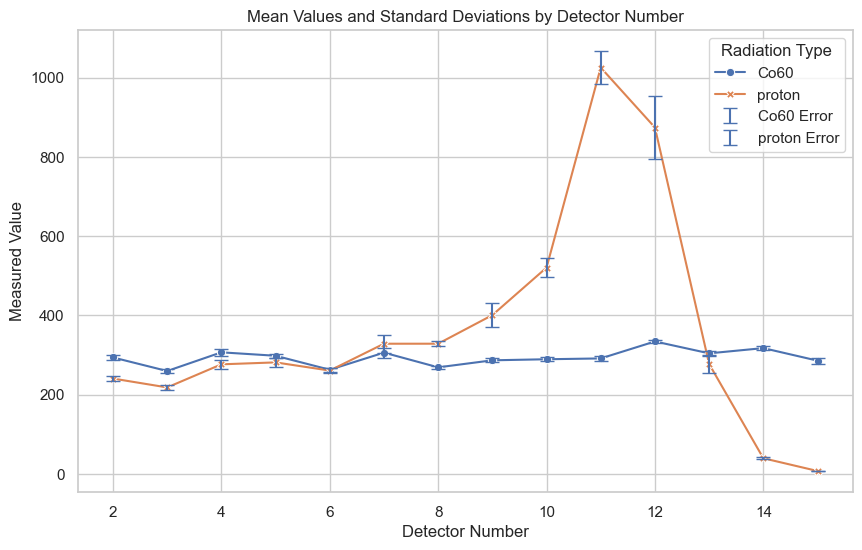

In [4]:
# Reset the index if df2 is a MultiIndex DataFrame
df2_reset = df2.reset_index()

# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Plot the mean values with line and scatter points
sns.lineplot(data=df2_reset, x='det_no', y='mean', hue='radiation', style='radiation', markers=True, dashes=False)

# Add error bars
for radiation_type in df2_reset['radiation'].unique():
    subset = df2_reset[df2_reset['radiation'] == radiation_type]
    plt.errorbar(subset['det_no'], subset['mean'], yerr=subset['std'], fmt='none', capsize=5, label=f'{radiation_type} Error')

plt.title('Mean Values and Standard Deviations by Detector Number')
plt.xlabel('Detector Number')
plt.ylabel('Measured Value')
plt.legend(title='Radiation Type')

# Bragg peak data from dosimetry and MC

In [5]:
base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'
base_path.exists()

True

In [6]:
plots_path = base_path / '2024-05-28_PB_silicon_20Gy' / 'article-plots.h5'
df_bp_exp = pd.read_hdf(plots_path, key='bp_exp')
df_bp_mc = pd.read_hdf(plots_path, key='bp_mc')

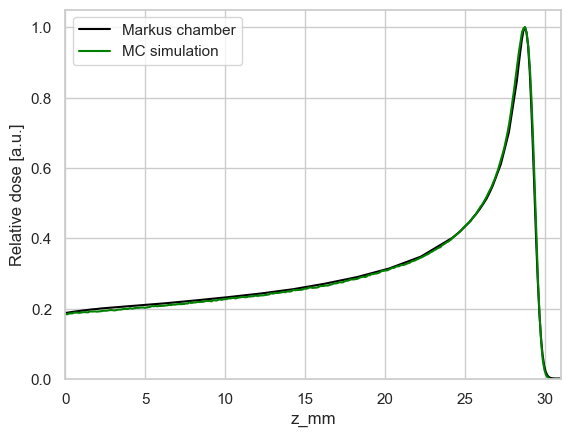

In [7]:
fig, ax_up = plt.subplots(nrows=1, sharex=True)
df_bp_exp.plot(ax=ax_up, x='Depth', y='Signal', label='Markus chamber', color='black', style='-')
df_bp_mc.plot(ax=ax_up, x='z_mm', y='dose', label='MC simulation', color='green', style='-')
ax_up.set_ylim(0,1.05)
ax_up.set_xlim(0, 31)
ax_up.set_ylabel("Relative dose [a.u.]");

# Detector positions

In [8]:
xls_path = base_path / '2024-05-28_PB_silicon_20Gy' / 'Pozycje_det.xlsx'
df_pos = pd.read_excel(xls_path, 
    skiprows=6, 
    nrows=31, 
    usecols="A,C,D,E",
    names=["det_no", "name", "det_thick", "WER"]
    )
# add new column det_start which is sum of WER for all indexes lower than current
df_pos['det_end'] = df_pos.WER.cumsum()
df_pos['det_begin'] = df_pos.det_end - df_pos.WER
df_pos = df_pos[df_pos.name == 'folia MBO']
df_pos.drop("name", axis=1, inplace=True)
df_pos['det_mid'] = (df_pos.det_begin + df_pos.det_end) / 2
df_pos.det_no = df_pos.det_no.astype(int)
df_pos

,det_no,det_thick,WER,det_end,det_begin,det_mid
0,2,0.43,0.4515,0.4515,0.0000,0.22575
3,3,0.43,0.4515,3.7780,3.3265,3.55225
6,4,0.42,0.4410,7.0710,6.6300,6.85050
9,5,0.44,0.4620,10.3850,9.9230,10.15400
12,6,0.44,0.4620,13.4345,12.9725,13.20350
15,7,0.42,0.4410,16.4285,15.9875,16.20800
18,8,0.46,0.4830,19.4875,19.0045,19.24600
21,9,0.43,0.4515,22.4460,21.9945,22.22025
24,10,0.43,0.4515,25.4160,24.9645,25.19025
26,11,0.44,0.4620,28.3965,27.9345,28.16550


In [9]:
# join df_reset with df_pos on det_no
df_reset_pos = df2_reset.join(df_pos.set_index('det_no'), on='det_no')
df_reset_pos

,radiation,det_no,mean,std,det_thick,WER,det_end,det_begin,det_mid
0,Co60,2,293.958297,5.283159,0.43,0.4515,0.4515,0.0000,0.22575
1,Co60,3,259.751904,5.445506,0.43,0.4515,3.7780,3.3265,3.55225
2,Co60,4,306.881430,8.497562,0.42,0.4410,7.0710,6.6300,6.85050
3,Co60,5,298.239225,4.873268,0.44,0.4620,10.3850,9.9230,10.15400
4,Co60,6,262.931823,4.922753,0.44,0.4620,13.4345,12.9725,13.20350
5,Co60,7,306.109932,12.726056,0.42,0.4410,16.4285,15.9875,16.20800
6,Co60,8,269.006936,4.157138,0.46,0.4830,19.4875,19.0045,19.24600
7,Co60,9,286.741279,5.084650,0.43,0.4515,22.4460,21.9945,22.22025
8,Co60,10,289.412934,5.527264,0.43,0.4515,25.4160,24.9645,25.19025
9,Co60,11,291.488228,6.337839,0.44,0.4620,28.3965,27.9345,28.16550


(0.0, 30.0)

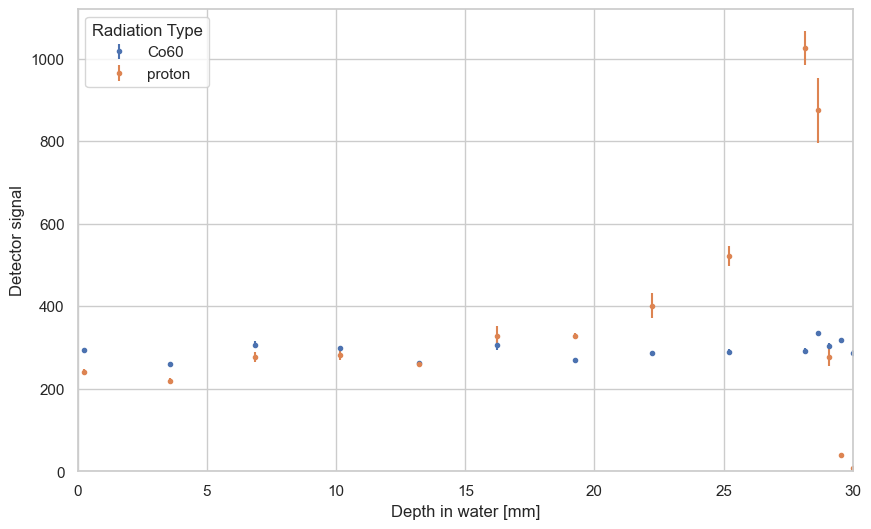

In [10]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean'], yerr=subset['std'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Detector signal')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

# Dose per detector

In [11]:
df_bp_mc

,zlower_cm,zupper_cm,dose,r.err,z_mm,dose_Gy
26,0.00,0.01,0.184743,0.0033,0.05,20.000000
27,0.01,0.02,0.184782,0.0034,0.15,20.004237
28,0.02,0.03,0.187052,0.0049,0.25,20.249965
29,0.03,0.04,0.186947,0.0041,0.35,20.238667
30,0.04,0.05,0.187195,0.0049,0.45,20.265499
...,...,...,...,...,...,...
421,3.95,3.96,0.000006,0.4542,39.55,0.000676
422,3.96,3.97,0.000016,0.5727,39.65,0.001760
423,3.97,3.98,0.000025,0.7804,39.75,0.002744
424,3.98,3.99,0.000028,0.7334,39.85,0.003082


In [12]:
# create spline interpolator object from scipy for x = df_bp_mc.z_mm and y = df_bp_mc.dose

f = interp1d(df_bp_mc.z_mm, df_bp_mc.dose, kind='cubic')

In [13]:
df_bp_mc.iloc[0].dose

0.1847426230791307

In [14]:
# for such rows of df_reset_pos where radiation is 'proton' calculate 'dose' as f(df_reset_pos.det_mid)
entrance_dose_protons_Gy = 20
dose_Co60 = 20
df_reset_pos.loc[df_reset_pos.radiation == 'proton', 'dose'] = f(df_reset_pos[df_reset_pos.radiation == 'proton'].det_mid) / df_bp_mc.iloc[0].dose * entrance_dose_protons_Gy
df_reset_pos.loc[df_reset_pos.radiation == 'Co60', 'dose'] = dose_Co60

In [15]:
df_reset_pos['mean_signal_per_Gy'] = df_reset_pos['mean'] / df_reset_pos['dose']
df_reset_pos['std_signal_per_Gy'] = df_reset_pos['std'] / df_reset_pos['dose']
df_reset_pos

,radiation,det_no,mean,std,det_thick,WER,det_end,det_begin,det_mid,dose,mean_signal_per_Gy,std_signal_per_Gy
0,Co60,2,293.958297,5.283159,0.43,0.4515,0.4515,0.0000,0.22575,20.000000,14.697915,0.264158
1,Co60,3,259.751904,5.445506,0.43,0.4515,3.7780,3.3265,3.55225,20.000000,12.987595,0.272275
2,Co60,4,306.881430,8.497562,0.42,0.4410,7.0710,6.6300,6.85050,20.000000,15.344071,0.424878
3,Co60,5,298.239225,4.873268,0.44,0.4620,10.3850,9.9230,10.15400,20.000000,14.911961,0.243663
4,Co60,6,262.931823,4.922753,0.44,0.4620,13.4345,12.9725,13.20350,20.000000,13.146591,0.246138
5,Co60,7,306.109932,12.726056,0.42,0.4410,16.4285,15.9875,16.20800,20.000000,15.305497,0.636303
6,Co60,8,269.006936,4.157138,0.46,0.4830,19.4875,19.0045,19.24600,20.000000,13.450347,0.207857
7,Co60,9,286.741279,5.084650,0.43,0.4515,22.4460,21.9945,22.22025,20.000000,14.337064,0.254233
8,Co60,10,289.412934,5.527264,0.43,0.4515,25.4160,24.9645,25.19025,20.000000,14.470647,0.276363
9,Co60,11,291.488228,6.337839,0.44,0.4620,28.3965,27.9345,28.16550,20.000000,14.574411,0.316892


(0.0, 30.0)

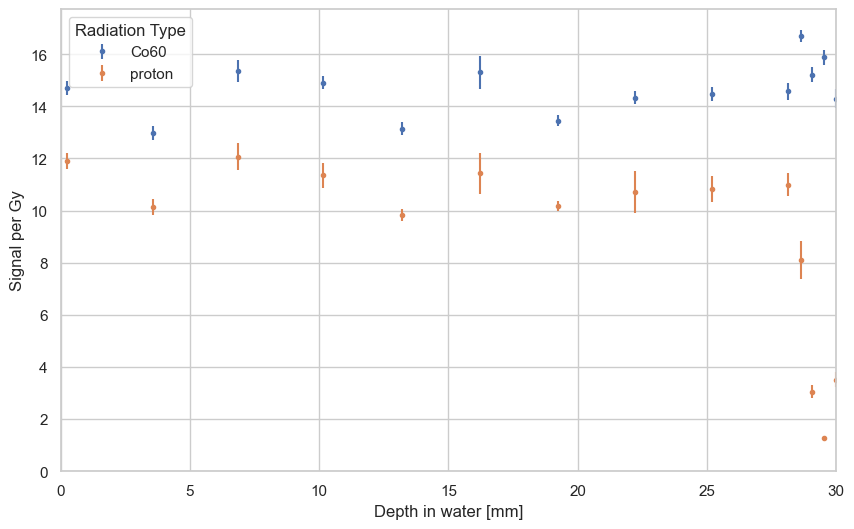

In [16]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean_signal_per_Gy'], yerr=subset['std_signal_per_Gy'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Signal per Gy')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

In [17]:
co60_data = df_reset_pos.loc[df_reset_pos.radiation == 'Co60']
proton_data = df_reset_pos.loc[df_reset_pos.radiation == 'proton']
all_data = co60_data.merge(proton_data, on='det_no', suffixes=['_Co60', '_proton'])
all_data['mean_efficiency'] = all_data['mean_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
numerator_relative_std = all_data['std_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
denominator_term = all_data['mean_signal_per_Gy_proton'] * all_data['std_signal_per_Gy_Co60'] / (all_data['mean_signal_per_Gy_Co60']**2)
all_data['std_efficiency'] = numerator_relative_std + denominator_term

In [18]:
all_data = all_data[all_data.det_no < 14]

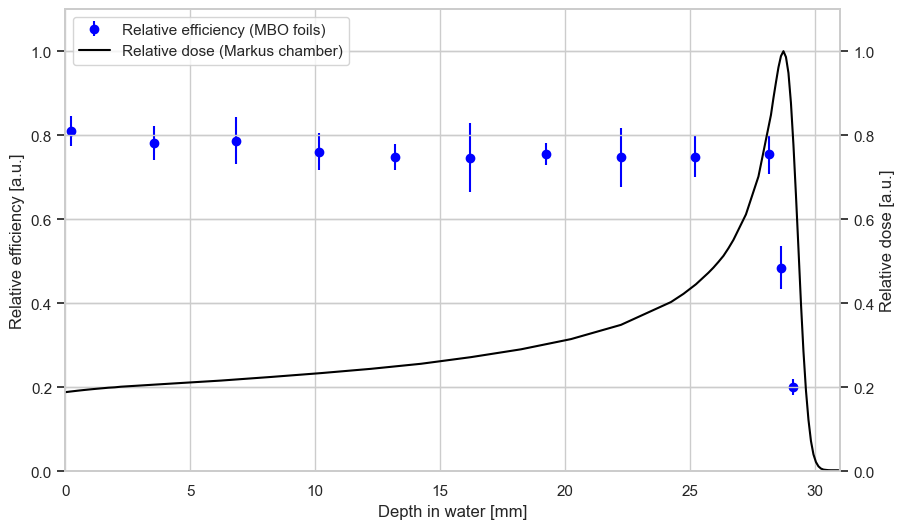

In [60]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')
ax.patch.set_alpha(0)
ax.errorbar(all_data['det_mid_proton'], all_data['mean_efficiency'], yerr=all_data['std_efficiency'], ls='', marker='o', label=f'Relative efficiency (MBO foils)', color='blue')
ax_twin = ax.twinx()
df_bp_exp.plot(ax=ax_twin, x='Depth', y='Signal', color='black', style='-', label='Relative dose (Markus chamber)')
ax.set_xlabel('Depth in water [mm]')
ax.set_ylabel('Relative efficiency [a.u.]')
ax_twin.set_ylabel('Relative dose [a.u.]')
ax.set_ylim(0,1.1)
ax.set_xlim(0,31)
ax_twin.set_xlim(0,31)
ax_twin.set_ylim(0,1.1)

# create legends for both axis
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax_twin.legend(lines + lines2, labels + labels2, loc='upper left')

fig.savefig(base_path / '2024-05-28_PB_silicon_20Gy' / 'data'  / 'interim' / 'PB_20Gy' / 'efficiency_and_dose.svg')


# Kinetic energy

In [48]:
df_bp_kin_en = pd.read_hdf(plots_path, key='bp_kin_en')

In [49]:
from scipy.interpolate import UnivariateSpline
bp_kin_en_spl = UnivariateSpline(df_bp_kin_en.z_mm.values, df_bp_kin_en.ef_q50.values)

In [50]:
all_data['ekin_MeV'] = bp_kin_en_spl(all_data['det_mid_proton'])

In [51]:
all_data

,radiation_Co60,det_no,mean_Co60,std_Co60,det_thick_Co60,WER_Co60,det_end_Co60,det_begin_Co60,det_mid_Co60,dose_Co60,...,WER_proton,det_end_proton,det_begin_proton,det_mid_proton,dose_proton,mean_signal_per_Gy_proton,std_signal_per_Gy_proton,mean_efficiency,std_efficiency,ekin_MeV
0,Co60,2,293.958297,5.283159,0.43,0.4515,0.4515,0.0000,0.22575,20.0,...,0.4515,0.4515,0.0000,0.22575,20.206402,11.912301,0.315582,0.810476,0.036037,58.253154
1,Co60,3,259.751904,5.445506,0.43,0.4515,3.7780,3.3265,3.55225,20.0,...,0.4515,3.7780,3.3265,3.55225,21.506662,10.151017,0.305858,0.781593,0.039936,53.373918
2,Co60,4,306.881430,8.497562,0.42,0.4410,7.0710,6.6300,6.85050,20.0,...,0.4410,7.0710,6.6300,6.85050,22.921722,12.067710,0.521850,0.786474,0.055787,49.281308
3,Co60,5,298.239225,4.873268,0.44,0.4620,10.3850,9.9230,10.15400,20.0,...,0.4620,10.3850,9.9230,10.15400,24.802316,11.349542,0.473288,0.761103,0.044175,45.455507
4,Co60,6,262.931823,4.922753,0.44,0.4620,13.4345,12.9725,13.20350,20.0,...,0.4620,13.4345,12.9725,13.20350,26.543545,9.827649,0.222031,0.747544,0.030885,41.760400
5,Co60,7,306.109932,12.726056,0.42,0.4410,16.4285,15.9875,16.20800,20.0,...,0.4410,16.4285,15.9875,16.20800,28.764070,11.424176,0.779233,0.746410,0.081943,37.596526
6,Co60,8,269.006936,4.157138,0.46,0.4830,19.4875,19.0045,19.24600,20.0,...,0.4830,19.4875,19.0045,19.24600,32.321206,10.167776,0.191156,0.755949,0.025894,32.495457
7,Co60,9,286.741279,5.084650,0.43,0.4515,22.4460,21.9945,22.22025,20.0,...,0.4515,22.4460,21.9945,22.22025,37.403185,10.716185,0.811114,0.747446,0.069829,26.283384
8,Co60,10,289.412934,5.527264,0.43,0.4515,25.4160,24.9645,25.19025,20.0,...,0.4515,25.4160,24.9645,25.19025,48.029588,10.840225,0.505068,0.749118,0.049210,18.533086
9,Co60,11,291.488228,6.337839,0.44,0.4620,28.3965,27.9345,28.16550,20.0,...,0.4620,28.3965,27.9345,28.16550,93.240532,10.997752,0.441347,0.754593,0.046689,8.876182


(0.0, 60.0)

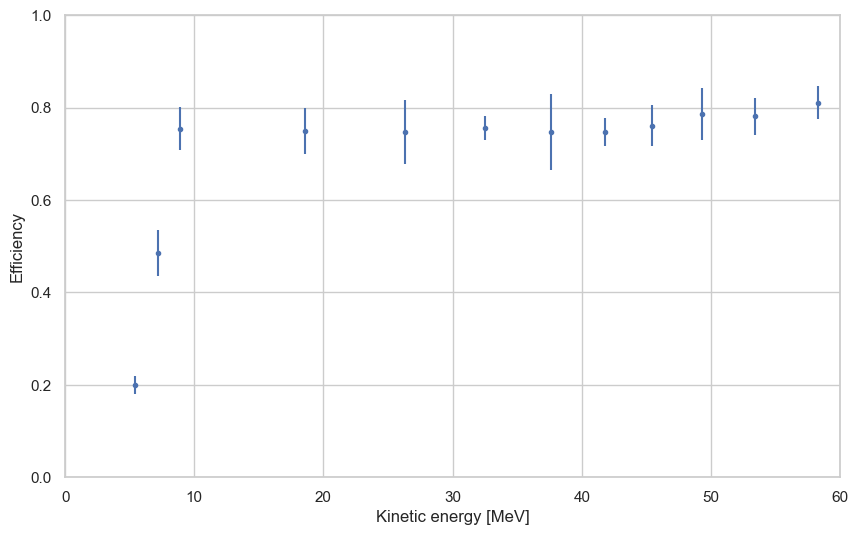

In [52]:
plt.figure(figsize=(10, 6))
plt.errorbar(all_data['ekin_MeV'], all_data['mean_efficiency'], yerr=all_data['std_efficiency'], ls='', marker='.', label=f'efficiency')
plt.xlabel('Kinetic energy [MeV]')
plt.ylabel('Efficiency')
plt.ylim(0,1)
plt.xlim(0,60)

In [53]:

x_values_for_fit = all_data['ekin_MeV']
y_values_for_fit = all_data['mean_efficiency']
#mod = StepModel(form='logistic')
step_mod = StepModel(form='atan')
#lin_mod = LinearModel()
pars = step_mod.guess(y_values_for_fit, x=x_values_for_fit)
#pars += lin_mod.guess(y_values_for_fit, x=x_values_for_fit)
#pars['intercept'].min = 1e-5
#pars['amplitude'].min = 1e-5
#mod = step_mod + lin_mod
mod = step_mod
out = mod.fit(y_values_for_fit, pars, x=x_values_for_fit)
x_for_plotting = np.linspace(0,60,num=100)
y_for_plotting = out.eval(x=x_for_plotting)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(step, form='atan')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 12
    # variables        = 3
    chi-square         = 0.01133512
    reduced chi-square = 0.00125946
    Akaike info crit   = -77.5770709
    Bayesian info crit = -76.1223510
    R-squared          = 0.96674960
[[Variables]]
    amplitude:  0.78014522 +/- 0.01214204 (1.56%) (init = 0.6103038)
    center:     6.60830341 +/- 0.17166924 (2.60%) (init = 31.83538)
    sigma:      1.00632936 +/- 0.20550761 (20.42%) (init = 7.547935)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = +0.2863


(0.0, 1.0)

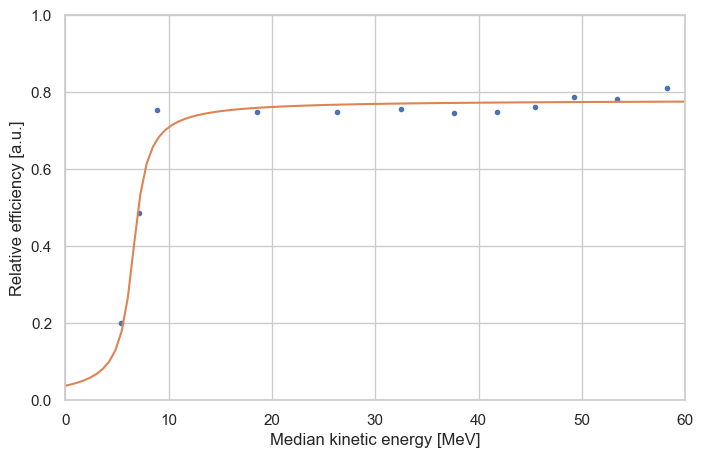

In [54]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(all_data['ekin_MeV'], all_data['mean_efficiency'], marker=".", linestyle="")
ax.plot(x_for_plotting, y_for_plotting)
ax.set_xlabel('Median kinetic energy [MeV]')
ax.set_ylabel('Relative efficiency [a.u.]')
ax.set_xlim(0,60)
ax.grid(True)
ax.set_ylim(0,1)

In [55]:
from lmfit.model import save_modelresult, save_model
base_output_path = base_path / '2024-05-28_PB_silicon_20Gy' / 'data' / 'interim'
model_output_path = base_output_path / 'PB_20Gy'
#print(model_output_path)
save_model(mod, model_output_path / 'model.sav')
save_modelresult(out, model_output_path / 'model_result.sav')

In [56]:
all_data.columns

Index(['radiation_Co60', 'det_no', 'mean_Co60', 'std_Co60', 'det_thick_Co60',
       'WER_Co60', 'det_end_Co60', 'det_begin_Co60', 'det_mid_Co60',
       'dose_Co60', 'mean_signal_per_Gy_Co60', 'std_signal_per_Gy_Co60',
       'radiation_proton', 'mean_proton', 'std_proton', 'det_thick_proton',
       'WER_proton', 'det_end_proton', 'det_begin_proton', 'det_mid_proton',
       'dose_proton', 'mean_signal_per_Gy_proton', 'std_signal_per_Gy_proton',
       'mean_efficiency', 'std_efficiency', 'ekin_MeV'],
      dtype='object')

In [57]:
all_data[['det_no', 'ekin_MeV', 'dose_proton', 'det_mid_proton', 'mean_efficiency', 'std_efficiency', 'mean_signal_per_Gy_Co60']].to_hdf(model_output_path / 'detectors_data.h5', key='df')